<img src="https://5264302.fs1.hubspotusercontent-na1.net/hubfs/5264302/Demo%20Asset%20Resources/Demo%20Covers/CM-Demo-hourly_metrics-Cover.png" width=1100 margin-left='auto' margin-right='auto'/>

## Resources
This notebook demonstrates basic functionality offered by the Coin Metrics Python API Client and Network Data Pro.

Coin Metrics offers a vast assortment of data for hundreds of cryptoassets. The Python API Client allows for easy access to this data using Python without needing to create your own wrappers using `requests` and other such libraries.

To understand the data that Coin Metrics offers, feel free to peruse the resources below.

- The [Coin Metrics API v4](https://docs.coinmetrics.io/api/v4) website contains the full set of endpoints and data offered by Coin Metrics.
- The [Coin Metrics Knowledge Base](https://docs.coinmetrics.io/info) gives detailed, conceptual explanations of the data that Coin Metrics offers.
- The [API Spec](https://coinmetrics.github.io/api-client-python/site/api_client.html) contains a full list of functions.

### Notebook Setup

In [1]:
from os import environ
import pandas as pd
import numpy as np
import seaborn as sns
import logging
from datetime import date, datetime, timedelta
from coinmetrics.api_client import CoinMetricsClient
import logging
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FuncFormatter
import warnings
%matplotlib inline

In [2]:
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)
matplotlib.rcParams['font.family'] = 'arial'

In [3]:
# We recommend privately storing your API key in your local environment.
try:
    api_key = environ["CM_API_KEY"]
    logging.info("Using API key found in environment")
except KeyError:
    api_key = ""
    logging.info("API key not found. Using community client")
client = CoinMetricsClient(api_key)

2024-10-04 11:52:04 INFO     Using API key found in environment


# Hourly Metrics

Coin Metrics is pleased to announce the release of a new set of hourly metrics for **Network Data Pro**. This feature unlocks a new level granularity for our existing suite of on-chain metrics. 

Previously, our Network Data Pro offering provided both Daily (EOD) and Block-by-Block (BBB) aggregations of on-chain metrics. Now, users have the ability to capture on-chain activity at an intermediate frequency, providing timely insights into metrics like Active Address Count, Transaction Fees, and more.

### Retrieve Hourly Metrics Catalog

In [4]:
asset_metrics_reference = client.reference_data_asset_metrics(page_size=10000).to_dataframe()
list_metrics_nd = list(asset_metrics_reference.loc[asset_metrics_reference['product']=='Network Data', 'metric'])

asset_metrics_catalog = client.catalog_asset_metrics_v2(
    assets='eth', 
    metrics=list_metrics_nd, 
    page_size=10000
).to_list()


list_hourly_metrics_nd = []
for asset in asset_metrics_catalog:
    for metric in asset['metrics']:
        if 'frequencies' in metric.keys():
            for frequency in metric.get('frequencies'):
                if '1h' in frequency.values():
                    list_hourly_metrics_nd.append(metric['metric'])

# # alternatively, use this dataframe. note this is only doable starting coinmetrics-api-client version 2024.10.4.15
# asset_metrics_catalog = client.catalog_asset_metrics_v2(page_size=10000).to_dataframe()
# list_hourly_metrics_nd = list(asset_metrics_catalog.loc[asset_metrics_catalog.frequency=='1h', 'metric'].unique())

['AdrActBlobCnt',
 'AdrActBlobContRecCnt',
 'AdrActBlobRecCnt',
 'AdrActBlobSendCnt',
 'AdrActCnt',
 'AdrActRecCnt',
 'AdrActSentCnt',
 'AssetCompletionTime',
 'BlkCnt',
 'BlkHgt',
 'BlkIntMean',
 'BlkSizeByte',
 'BlobARBSizeByte',
 'BlobBASESizeByte',
 'BlobCnt',
 'BlobContCnt',
 'BlobInscrCnt',
 'BlobL2SizeByte',
 'BlobMeanCnt',
 'BlobOPSizeByte',
 'BlobSizeAllTimeByte',
 'BlobSizeByte',
 'BlobUniqCnt',
 'DiffLast',
 'FeeBlobARBMeanNtv',
 'FeeBlobARBMeanUSD',
 'FeeBlobARBTotNtv',
 'FeeBlobARBTotUSD',
 'FeeBlobBASEMeanNtv',
 'FeeBlobBASEMeanUSD',
 'FeeBlobBASETotNtv',
 'FeeBlobBASETotUSD',
 'FeeBlobByteMeanNtv',
 'FeeBlobByteMeanUSD',
 'FeeBlobL2MeanNtv',
 'FeeBlobL2MeanUSD',
 'FeeBlobL2TotNtv',
 'FeeBlobL2TotUSD',
 'FeeBlobMeanNtv',
 'FeeBlobMeanUSD',
 'FeeBlobMedNtv',
 'FeeBlobMedUSD',
 'FeeBlobOPMeanNtv',
 'FeeBlobOPMeanUSD',
 'FeeBlobOPTotNtv',
 'FeeBlobOPTotUSD',
 'FeeBlobTotNtv',
 'FeeBlobTotUSD',
 'FeeBlobTxMeanNtv',
 'FeeBlobTxMeanUSD',
 'FeeMeanNtv',
 'FeeMeanUSD',
 'FeeMedNt

# Example Analyses

In [6]:
start = datetime.utcnow() - timedelta(days=7)

## ETH Fee Burn vs. Tx Count

First, we'll examine the relationship between Ethereum's transaction count (**TxCnt**) and the amount of ETH being "burned," or removed from circulation (**SplyBurntNtv**). 

Since the introduction of EIP-1559, Ethereum has segmented gas fees into two separate fees: the "base fee" and the "priority tip." While the priority tip is rewarded to validators, the base fee is burnt. Over the long-term, this has enabled ETH to offer a deflationary monetary policy, with periods of high transaction activity permanently destroying units of ETH and lowering the total circulating supply. 

For more details on the impact of EIP-1559, check out [**State of the Network #166: Ethereum After EIP-1559**](https://coinmetrics.substack.com/p/state-of-the-network-issue-166)

In [7]:
fee_burn_and_tx_metrics = client.get_asset_metrics(
    assets='eth',
    metrics=['TxCnt','SplyBurntNtv'],
    start_time = start,
    frequency='1h'
).to_dataframe()

In [8]:
fee_burn_and_tx_metrics['time'] = pd.to_datetime(fee_burn_and_tx_metrics['time'])

In [9]:
fee_burn_and_tx_metrics = fee_burn_and_tx_metrics[['SplyBurntNtv','TxCnt','time']].set_index('time')
fee_burn_and_tx_metrics['SplyBurntNtv'] = fee_burn_and_tx_metrics['SplyBurntNtv'] * -1
fee_burn_and_tx_metrics

,SplyBurntNtv,TxCnt
time,,
2024-09-27 17:00:00+00:00,-70.397819,53103
2024-09-27 18:00:00+00:00,-50.973631,52695
2024-09-27 19:00:00+00:00,-129.348614,49882
2024-09-27 20:00:00+00:00,-64.472321,52184
2024-09-27 21:00:00+00:00,-39.452127,50770
...,...,...
2024-10-04 11:00:00+00:00,-19.116498,48958
2024-10-04 12:00:00+00:00,-27.192417,49215
2024-10-04 13:00:00+00:00,-39.860415,49662


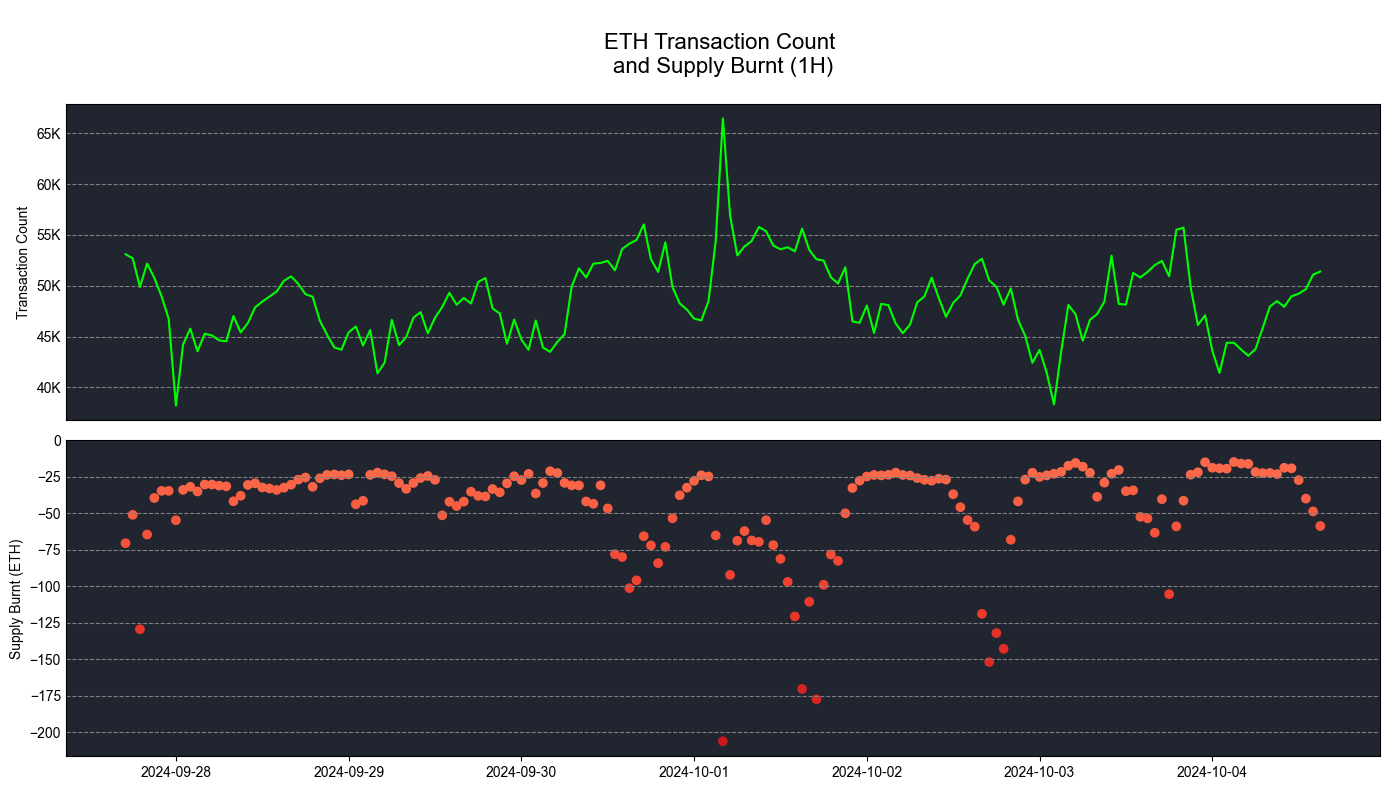

In [10]:
# Function to format y-axis tick labels
def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(14,8))
ax1.set_title('\nETH Transaction Count \nand Supply Burnt (1H)\n', color='black', fontsize=16)  # Change title color to white for visibility

# Plot TxCnt as a line plot
ax1.plot(fee_burn_and_tx_metrics.index, fee_burn_and_tx_metrics['TxCnt'], color='lime')
ax1.set_facecolor('#212530')
ax1.set_ylabel('Transaction Count', color='black')  
ax1.tick_params(length=0, axis='y', labelcolor='black') 
ax1.tick_params(length=0, axis='x', labelcolor='black')  
ax1.yaxis.set_major_formatter(FuncFormatter(thousands))
ax1.grid(axis='y',linestyle='--', color='gray')  # Change gridline color to white for visibility

cmap = matplotlib.cm.Reds(np.linspace(0.5,0.75,20))
cmap = matplotlib.colors.ListedColormap(cmap[::-1, :-1])

# Plot SplyBurntUSD as a scatter plot with the colormap
sc = ax2.scatter(fee_burn_and_tx_metrics.index, fee_burn_and_tx_metrics['SplyBurntNtv'], c=fee_burn_and_tx_metrics['SplyBurntNtv'], cmap=cmap)
ax2.set_facecolor('#212530')
ax2.set_xlabel('')
ax2.set_ylabel('Supply Burnt (ETH)', color='black')  # Change label color to white for visibility
ax2.tick_params(length=0,axis='y', labelcolor='black')  # Change tick color to white for visibility
ax2.grid(axis='y',linestyle='--', color='gray')  # Change gridline color to white for visibility
ax2.set_ylim(fee_burn_and_tx_metrics['SplyBurntNtv'].min()*1.05,0)
fig.tight_layout()
plt.show()

## BTC Block Interval vs. Mean Fee

In contrast to Etheruem's predictable 12-second block time, Bitcoin's block interval is based on probabilistic factors— there's no way of knowing for sure when the next block will come in. 

The blockchain's difficulty adjustment software targets an average block interval of 10 minutes, but blocks can occasionally take an hour or more to be mined, resulting in brief periods of transaction congestion. This congestion can result in spikes in transaction fees, as a busy backlog of BTC users bid up fees in order to ensure their inclusion in the next block.

In the following analysis, we examine how Bitcoin's median transaction fee (**FeeMedUSD**) responds to prolonged block intervals (**BlkIntMean**).

In [11]:
blk_size_and_fee_metrics = client.get_asset_metrics(
    assets='btc',
    metrics=['BlkIntMean','FeeMedUSD'],
    start_time = start,
    frequency='1h'
).to_dataframe()

In [12]:
blk_size_and_fee_metrics['time'] = pd.to_datetime(blk_size_and_fee_metrics['time'])
blk_size_and_fee_metrics['FeeMedUSD'] = blk_size_and_fee_metrics['FeeMedUSD'].replace('None', np.nan).astype(float)
blk_size_and_fee_metrics['BlkIntMean'] = blk_size_and_fee_metrics['BlkIntMean'] / 60

In [13]:
blk_size_and_fee_metrics.set_index('time')

,asset,BlkIntMean,FeeMedUSD
time,,,
2024-09-27 17:00:00+00:00,btc,16.208333,1.289085
2024-09-27 18:00:00+00:00,btc,5.725,1.061119
2024-09-27 19:00:00+00:00,btc,12.443333,0.405089
2024-09-27 20:00:00+00:00,btc,5.090909,0.317237
2024-09-27 21:00:00+00:00,btc,10.326667,0.339649
...,...,...,...
2024-10-04 10:00:00+00:00,btc,8.87619,0.126917
2024-10-04 11:00:00+00:00,btc,5.666667,0.183543
2024-10-04 12:00:00+00:00,btc,15.95,0.208127


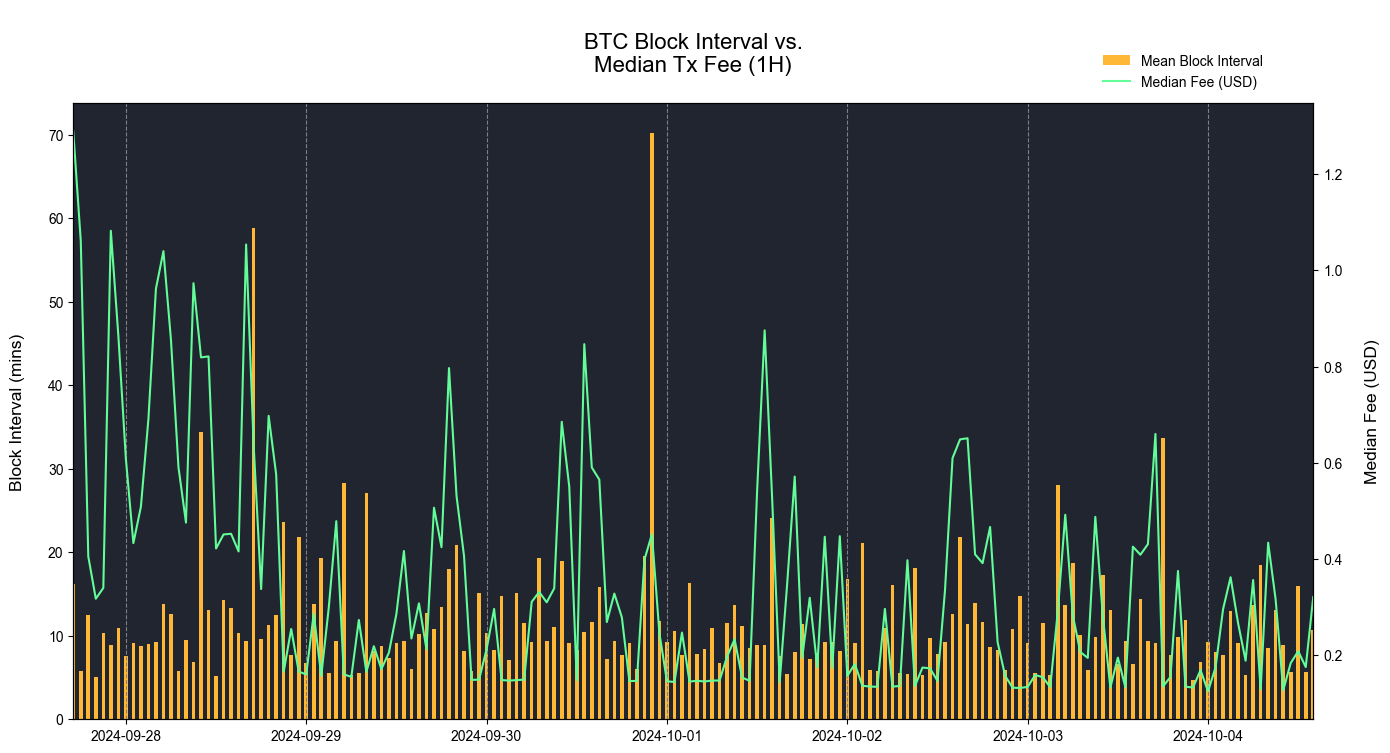

In [14]:
fig, ax1 = plt.subplots(figsize=(16,8))

# Calculate width of bars in terms of the time difference
width = 0.02

ax1.set_title('\nBTC Block Interval vs.\nMedian Tx Fee (1H)\n', color='black', fontsize=16)
ax1.set_facecolor('#212530')

# Bar chart for BlkIntMean
ax1.bar(blk_size_and_fee_metrics['time'], blk_size_and_fee_metrics['BlkIntMean'], width=width, color='#ffb836', label='Mean Block Interval')
ax1.set_xlabel('')
ax1.set_ylabel('Block Interval (mins)\n', fontsize=12.5)
ax1.tick_params(axis='y')

# Set x-axis limits
ax1.set_xlim([blk_size_and_fee_metrics['time'].min(), blk_size_and_fee_metrics['time'].max()])

ax1.grid(axis='x',linestyle='--', color='gray')  # Change gridline color to white for visibility
# Line chart for FeeMeanUSD on a second y-axis
ax2 = ax1.twinx()
ax2.plot(blk_size_and_fee_metrics['time'], blk_size_and_fee_metrics['FeeMedUSD'], color='#62fc98', label='Median Fee (USD)')
ax2.set_ylabel('\nMedian Fee (USD)', fontsize=12.5)
ax2.tick_params(axis='y')

# Display the legend
fig.legend(loc="upper left", bbox_to_anchor=(0.82,1.1), bbox_transform=ax1.transAxes, frameon=False)

plt.show()